# Johnson-Cook with 6 strain rates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("mime")
import pandas as pd
import h5py
from scipy.optimize import curve_fit
import lmfit

colors = ['#bb0000', '#00bb00', "#0000bb", '#bbbb00', '#bb00bb', "#00bbbb", '#bbbbbb', '#770000', '#007700', "#000077", '#777700', '#770077', "#007777", '#777777', '#440000', '#004400', "#000044", '#444400', '#440044', "#0044444", '#444444','#000000']

In [2]:
baseSize = (8, 6)  # Base size of a subplot

def sbPlot(n):
    if (n == 1): return 1, 1
    if (n <= 2): return 1, 2
    if (n <= 4): return 2, 2
    if (n <= 6): return 3, 2
    if (n <= 9): return 3, 3
    if (n <= 12): return 4, 3
    return 0, 0

def sbPlotSize(n):
    x, y = sbPlot(n)
    return baseSize[0] * y, baseSize[1] * x

In [3]:
h5f = h5py.File('../GleebleData.h5','r')
allData = h5f['all'][:]
shortData = h5f['short'][:]
h5f.close()

In [4]:
allData.shape, shortData.shape

((21030, 4), (1080, 4))

Remove first point of each curve, where $\varepsilon^p=0$

In [5]:
allData = allData[allData[:,0] != 0]
shortData = shortData[shortData[:,0]!=0]
identData = shortData

Remove data to reconstruct

In [6]:
missed = 1
identData = shortData[shortData[:,1] != missed]
identData.shape

(875, 4)

In [7]:
strains = np.unique(identData[:,0])
allStrains = np.unique(allData[:,0])
epsps = np.unique(identData[:,1])
temperatures = np.unique(identData[:,2])
nEps = len(strains)
nEpsp = len(epsps)
nTemp = len(temperatures)
strains, epsps, temperatures, nEps, nEpsp, nTemp

(array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
        0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
        0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
        0.68, 0.7 ]),
 array([1.e-03, 1.e-02, 1.e-01, 2.e+00, 5.e+00]),
 array([1050., 1100., 1150., 1200., 1250.]),
 35,
 5,
 5)

# Identification of the Johnson-Cook parameters
$\sigma = (A + B\varepsilon^n)\left(1 + C\ln\left(\frac{\dot{\varepsilon^p}}{\dot{\varepsilon^p}}\right)\right)\left(1-\left(\frac{T-T_0}{T_m - T_0}\right)^m\right)$

In [8]:
T0 = temperatures[0]
epsp0 = epsps[0]
Tm = 1460

A is the initial yield at reference strain rate and temperature

In [9]:
A = allData[(allData[:,1]==epsp0) & (allData[:,2]==T0)][0,3]
print("A=%g" %(A))

A=13.5143


Extract the reference curve data

In [10]:
Sig = identData[(identData[:,1]==epsp0) & (identData[:,2]==T0)]
params = np.polyfit(np.log(Sig[:,0]), np.log(Sig[:,3]-A), 1)
n, lnB = params
B = np.exp(lnB)
print("lnB=%g, B=%g, n=%g" %(lnB, B, n))

lnB=3.08264, B=21.816, n=0.0746257


Extract data at reference temperature

In [11]:
sigT0 = identData[identData[:,2]==T0]
sigT0[:,3] = ((sigT0[:,3])/(A + B*(sigT0[:,0])**n)) - 1

In [12]:
def specialFunction(x,s):
    return s*x

S1 = []
cl=0
for epsj in list(strains):
    sbdata = sigT0[sigT0[:,0]==epsj]
    popt, pcov = curve_fit(specialFunction, np.log(sbdata[:,1]/epsp0), sbdata[:,3], bounds=(-np.inf, [np.inf]))
    s = popt
    S1.append(s)
    cl +=1
C  = np.mean(S1)
print("C=%g" %(C))

C=0.342688


In [13]:
sigEpsp0 = identData[(identData[:,1]==epsp0) & (identData[:,2]!=T0)]
sigEpsp0[:,3] = 1 - (sigEpsp0[:,3]/((A + B*(sigEpsp0[:,0])**n)))

In [14]:
J1 = []
cl=0
for epsj in list(strains):
    sbdata = sigEpsp0[sigEpsp0[:,0]==epsj]
    #print(sbdata)
    popt, pcov = curve_fit(specialFunction, np.log((sbdata[:,2]-T0)/(Tm-T0)), np.log(sbdata[:,3]), bounds=(-np.inf, [np.inf]))
    m1 = popt
    J1.append(m1)
    cl +=1
m  = np.mean(J1)
print("m=%g" %(m))

m=0.705715


In [15]:
A,B,C,n,m

(13.51428,
 21.815987645444093,
 0.34268797010303664,
 0.07462570997436893,
 0.7057151050757855)

In [16]:
def JCconstitutiveLaw(eps, epsp, T):
    return (A + B * eps**n) * (1 + C * np.log(epsp / epsp0)) * (1 - ((T - T0) / (Tm - T0))**m)

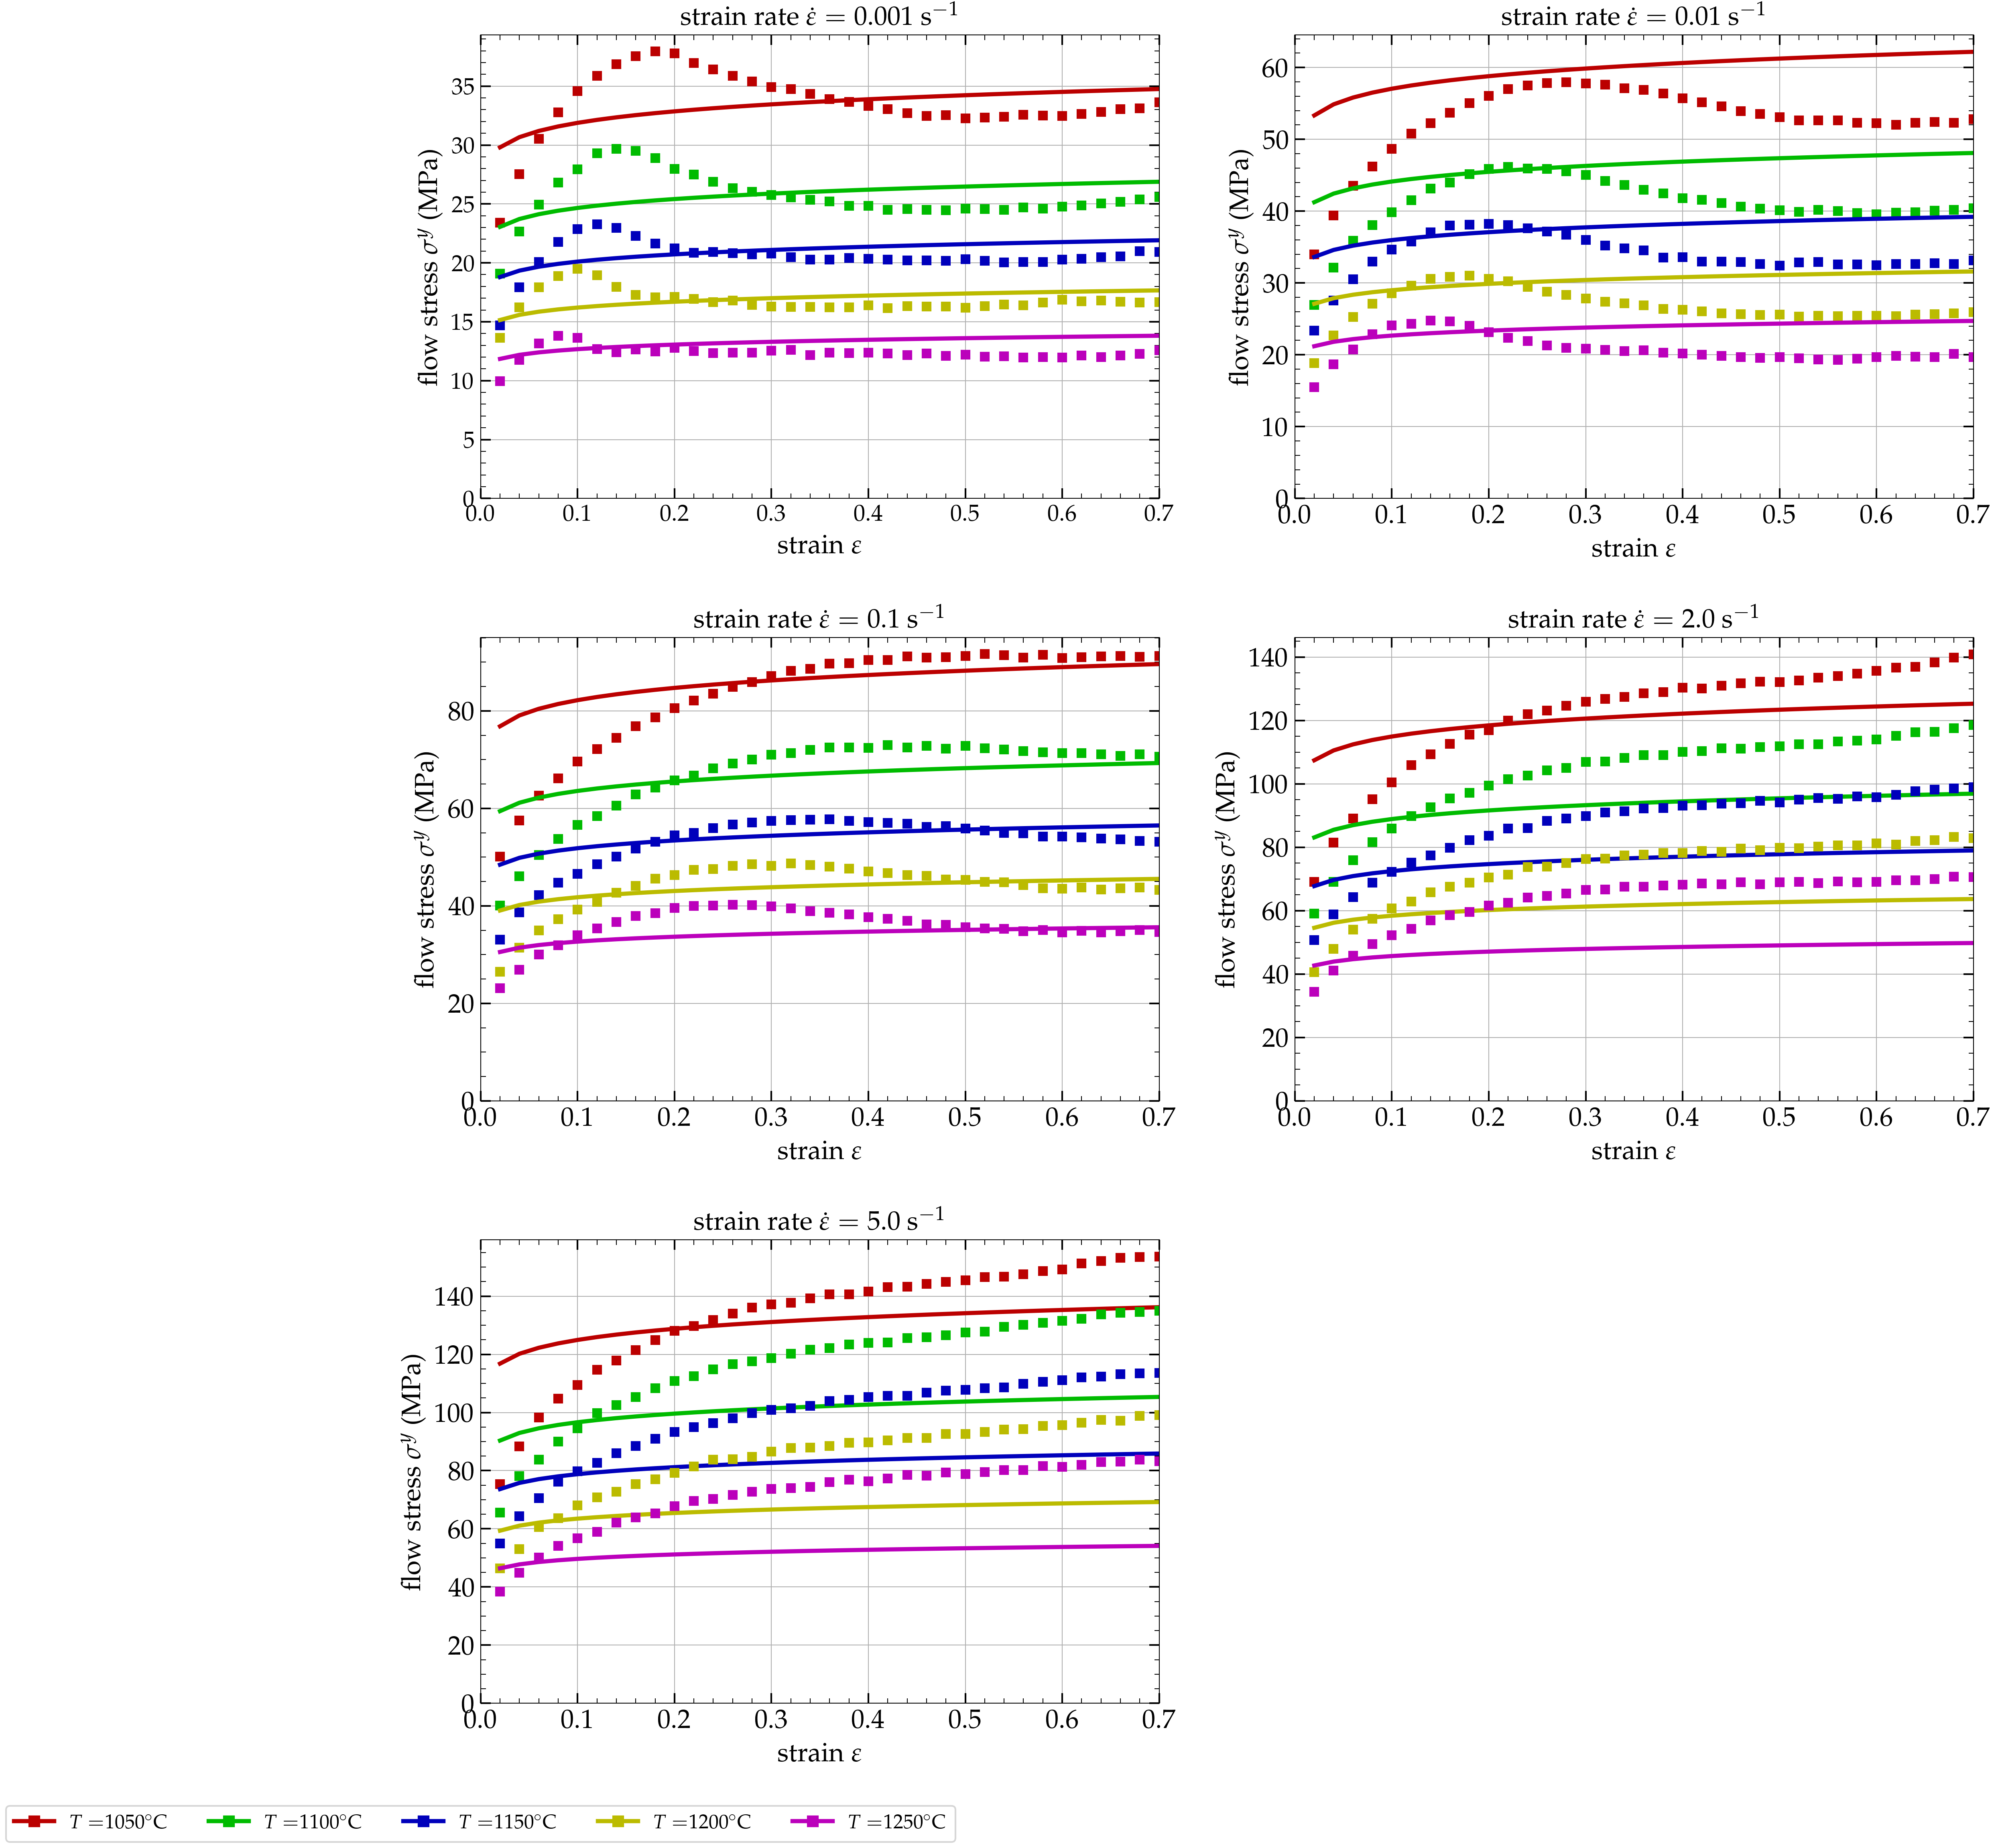

In [17]:
# Plot the curves
from matplotlib.lines import Line2D
def create_dummy_line(**kwds):
    return Line2D([], [], **kwds)

plt.figure(figsize = sbPlotSize(nEpsp))
plt.rc('text', usetex = True)
idx = 1
plt.subplots_adjust(hspace = 0.3)
for epsp in list(epsps):
    xs, ys = sbPlot(nEpsp)
    plt.subplot(xs, ys, idx)
    sbdata = shortData[shortData[:,1]==epsp]
    cl =0
    for temp in list(temperatures):
        sbdata1 = sbdata[sbdata[:,2]==temp]
        plt.plot(sbdata1[:,0], sbdata1[:,3], colors[cl], marker = 's', markersize = 5, linestyle = 'none')
        plt.plot(strains, JCconstitutiveLaw(strains, epsp, temp), colors[cl], linewidth = 2.5)
        plt.rcParams['xtick.labelsize'] = 16
        plt.rcParams['ytick.labelsize'] = 16
        cl +=1
    plt.xlim(0, 0.7)
    plt.ylim(bottom=0)
    plt.xlabel(r'strain $\varepsilon$', fontsize = 16) # Labels the x axis
    plt.ylabel(r'flow stress $\sigma^y$ (MPa)', fontsize = 16) # Labels the y axis
    plt.title(r'strain rate $\dot{\varepsilon} = ' + str(epsp) + '$ s$^{-1}$', fontsize = 16) # Self explicit command
    idx += 1
    
legendLines = []
cl = 0
for temp in list(temperatures):
    legendLines.append((r'$T=$' + str(int(temp)) + r'$^{\circ}$C', {'color':colors[cl], 'linestyle':'-', 'linewidth':2.5, 'marker':'s'}))
    cl += 1

plt.legend([create_dummy_line(**l[1]) for l in legendLines],[l[0] for l in legendLines], 
           loc = 'upper center', fontsize = 12, ncols = 5, bbox_to_anchor = (0.0, -0.2), shadow = False)

plt.savefig("CompExpJC-5i.svg")
plt.show()

In [18]:
JCstress = JCconstitutiveLaw(allData[:,0], allData[:,1], allData[:,2])

In [19]:
data = np.concatenate((allData[:,0:3],JCstress.reshape((JCstress.shape[0],1))),axis=1)
h5f = h5py.File('JC-5i.h5','w')
h5f.create_dataset('data', data = data)
h5f.close()

In [20]:
EAAR = np.sum(np.abs((allData[:,3] - JCstress)/(allData[:,3])))*100/JCstress.shape[0]
print("EAAR = %.2f" %(EAAR) + ' %')

EAAR = 13.97 %


In [21]:
RMSE = np.sqrt(np.sum((allData[:,3] - JCstress)**2)/allData.shape[0])
print('RMSE = %.2f' %(RMSE)+' MPa')

RMSE = 11.86 MPa


In [22]:
def outOf(val, i):
    if ((val<-i) or (val>i)): return True
    return False

def conv (v, d):
    va = abs(v)
    e = int(np.log10(va))
    if (va < 1): e-=1
    if outOf(e,2):
        a = v * 10**(-e)
        v = np.round(a * 10**d)/10**d
        return str(v)+'\\times 10^{'+str(e)+'}'
    v = np.round(v * 10**d)/10**d
    return str(v)

In [23]:
print('A =',conv(A,4))
print('B =',conv(B,4))
print('n =',conv(n,4))
print('C =',conv(C,4))
print('m =',conv(m,4))

A = 13.5143
B = 21.816
n = 0.0746
C = 0.3427
m = 0.7057
